In [1]:
import sys; sys.path.insert(0, '..') #Add upper folder to path
from src.preprocess import Preprocess
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import yaml

In [2]:
with open("../src/config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

features_cols = config['features']

max_runtime = 300000
algorithms = config['algorithms']
runtime_cols = [algorithm + ' Runtime' for algorithm in algorithms]
runtime_cols.append('Y Runtime')
success_cols = [algorithm + ' Success' for algorithm in algorithms]
data_path = '../src/AllData-labelled.csv'
df = pd.read_csv(data_path)

# drop_maps = None
drop_maps = ['warehouse']

if drop_maps is not None:
    for maptype in drop_maps:
        df = df[~df.GridName.str.contains(maptype)]
    df = df.reset_index(drop=True)

In [3]:
# features_cols.remove('2waycollisions')

In [4]:
success_cols

['icts Success', 'epea Success', 'sat Success', 'cbsh-c Success']

### How many problems solved by only one solver? ###

In [5]:
df['SolvesFinishedCount'] = df[success_cols].sum(axis=1)

In [6]:
print("{n} of the problems solved by only one solver!".format(n=len(df[df['SolvesFinishedCount']==1])/len(df)))

0.20864645228940928 of the problems solved by only one solver!


In [10]:
# df[(df['cbsh Success']==0)&(df['cbsh-c Success']==1)][['NumOfAgents','GridName','InstanceId']]

### What is the maximum number of agents solved for each map? ###

Note: A map is a combination of an instance and the grid.

In [11]:
max_agents_for_each_map_row_idxs =df.groupby(['GridName','InstanceId'])['NumOfAgents'].idxmax()

In [12]:
winners_df = df.iloc[max_agents_for_each_map_row_idxs][['NumOfAgents','Y','GridName','InstanceId']]
winners_df.sort_values(['NumOfAgents'], ascending=False).head(20)

,NumOfAgents,Y,GridName,InstanceId
34687,1280,sat Runtime,orz900d,4
39183,1274,sat Runtime,orz900d,20
42292,1000,sat Runtime,orz900d,10
30903,201,cbsh-c Runtime,Berlin_1_256,2
32083,200,cbsh-c Runtime,Berlin_1_256,16
45497,198,epea Runtime,empty-48-48,7
20211,195,cbsh-c Runtime,Paris_1_256,25
30964,192,cbsh-c Runtime,Berlin_1_256,3
32558,190,cbsh-c Runtime,Paris_1_256,22
14200,187,cbsh-c Runtime,Paris_1_256,20


### How many maps each solver solved alone? (i.e. gain in coverage) ###

In [13]:
df[df['SolvesFinishedCount']==1]['Y'].value_counts()

sat Runtime       5470
cbsh-c Runtime    2907
epea Runtime       558
cbsh Runtime       369
icts Runtime       168
astar Runtime       64
macbs Runtime        8
cbs Runtime          7
Name: Y, dtype: int64

Let's try to find patterns regarding the large amount of maps sat solved alone

### For each solver, how distributed are his "single solver" maps? ###

In other words - we want to check if there is a solver that wins by a large margin on a specific map (and therefore gains coverage).

In [14]:
df[(df['SolvesFinishedCount']==1)&(df.Y=='sat Runtime')].GridName.value_counts()

orz900d                3348
random-64-64-10         442
Berlin_1_256            260
empty-48-48             258
maze-32-32-4            148
empty-32-32             128
maze-32-32-2             97
random-64-64-20          87
den312d                  87
random-32-32-10          85
ht_chantry               81
lt_gallowstemplar_n      71
room-32-32-4             56
ost003d                  45
maze-128-128-2           38
Paris_1_256              37
den520d                  36
room-64-64-16            35
ht_mansion_n             33
Boston_0_256             30
room-64-64-8             28
maze-128-128-10          16
empty-16-16              15
random-32-32-20           5
lak303d                   3
brc202d                   1
Name: GridName, dtype: int64

### We can see that orz900d is highly dominated by sat. What will happen when we train the solver without it? ###
Although surprising, it didn't had impact on the results.


In [15]:
df[(df['SolvesFinishedCount']==1)&(df.Y=='sat Runtime')&(df.GridName=='orz900d')].InstanceId.value_counts()

4     1209
20    1198
10     941
Name: InstanceId, dtype: int64

### Which maps have the highest std in terms of "single solvers" across different configurations? ###

In [16]:
s = df[(df['SolvesFinishedCount']==1)].groupby(['GridName'])['Y'].value_counts()
s.std(level='GridName').sort_values(ascending=False)

GridName
orz900d                2124.855877
random-64-64-10         206.560726
brc202d                 165.462987
Paris_1_256             153.722152
Boston_0_256            132.887170
Berlin_1_256            130.340707
empty-48-48             126.258993
w_woundedcoast           92.359804
ost003d                  81.328039
maze-32-32-4             77.781746
lak303d                  68.704682
random-32-32-20          68.391033
empty-32-32              55.590167
room-64-64-16            46.740774
random-64-64-20          43.274704
ht_chantry               42.836900
ht_mansion_n             42.457822
lt_gallowstemplar_n      38.148831
den312d                  37.000000
empty-8-8                35.355339
room-32-32-4             30.315013
random-32-32-10          30.163996
empty-16-16              28.919428
maze-128-128-2           26.162951
den520d                  21.738599
maze-128-128-10          15.556349
room-64-64-8             12.529964
maze-32-32-2                   NaN
Name: Y, dt

### Interesting! We see that sat exceed in specific configurations of orz only, but when it does - it does so in an outstanding way and wins by a large margin over the others. 

1. What's so special about those specific configurations of orz?
2. How can we use that knowledge during the training of the AS model? Maybe it emposes a bias?

### What is the margin for each map between the largest number of agents solved and the 2nd best solver? ###

In [17]:
max_num_of_agents_for_two_solvers_per_map = df[df['SolvesFinishedCount']>=2].groupby(['GridName','InstanceId'])['NumOfAgents'].max()


In [18]:
max_num_of_agents_for_single_solver_per_map = df[df['SolvesFinishedCount']==1].groupby(['GridName','InstanceId'])['NumOfAgents'].max()

In [19]:
margin_from_single_solver = max_num_of_agents_for_single_solver_per_map - max_num_of_agents_for_two_solvers_per_map
margin_from_single_solver.sort_values(ascending=False).head(10)

GridName      InstanceId
orz900d       4             1209.0
              20            1198.0
              10             941.0
Paris_1_256   25              99.0
Berlin_1_256  16              89.0
              3               70.0
Paris_1_256   3               68.0
              22              66.0
Berlin_1_256  4               60.0
Paris_1_256   19              59.0
Name: NumOfAgents, dtype: float64

### Let's try to cluster the data given the features and try to see if those outliers (orz900d of instances 4,20,10) seems "strange" ###

In [22]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupShuffleSplit

groups = df['InstanceId']  # len of scenarios
gkf = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for index, (tr_ind, test_ind) in enumerate(gkf.split(df, df['Y'], groups)):
    X_train, X_test, y_train, y_test = df.iloc[tr_ind].copy(), df.iloc[test_ind].copy(), \
                                           df['Y'].iloc[tr_ind].copy(), df['Y'].iloc[test_ind].copy()
    
    features_cols_without_b_factor = features_cols.copy()
#     features_cols_without_b_factor.remove('BranchingFactor')
    print(features_cols_without_b_factor)
    kmeans = KMeans(n_clusters=len(success_cols)).fit(X_train[features_cols_without_b_factor])


['GridRows', 'GridColumns', 'NumOfAgents', 'NumOfObstacles', 'ObstacleDensity', 'AvgDistanceToGoal', 'MaxDistanceToGoal', 'MinDistanceToGoal', 'AvgStartDistances', 'AvgGoalDistances', 'PointsAtSPRatio', 'Sparsity']


### Finding "Breaking points"
Points on instances where adding a single agent caused a dramatic increase in runtime

In [114]:
jump = 1
breaks = df[(df['Y Runtime'].shift(-jump)>df['Y Runtime']**2)&(df['Y Runtime']>5)].index.to_list()
after_breaks = [b+jump for b in breaks]
breaks.extend(after_breaks)


In [115]:
breaks.sort()
len(breaks)/2

87.0

In [118]:
df.iloc[breaks][['NumOfAgents','Y Runtime','InstanceId','GridName']+features_cols].head(12)

,NumOfAgents,Y Runtime,InstanceId,GridName,GridRows,GridColumns,NumOfAgents,NumOfObstacles,ObstacleDensity,AvgDistanceToGoal,MaxDistanceToGoal,MinDistanceToGoal,AvgStartDistances,AvgGoalDistances,PointsAtSPRatio,Sparsity
680,4,20.4992,1,maze-128-128-2,128.0,128.0,4,5526.0,0.337280,514.000000,798.0,335.0,122.30000,332.30000,0.072510,0.000368
681,5,1898.5994,1,maze-128-128-2,128.0,128.0,5,5526.0,0.337280,615.800000,1023.0,335.0,300.13330,389.73330,0.096558,0.000460
733,7,31.9730,1,orz900d,656.0,1491.0,7,881493.0,0.901234,1502.000000,3049.0,12.0,501.50000,977.78570,0.004139,0.000072
734,8,2142.2500,1,orz900d,656.0,1491.0,8,881493.0,0.901234,1547.250000,3049.0,12.0,827.88890,999.38890,0.004987,0.000083
994,12,6.6219,1,room-32-32-4,32.0,32.0,12,342.0,0.333984,25.416667,50.0,2.0,19.76923,23.03846,0.215820,0.017595
995,13,332.5728,1,room-32-32-4,32.0,32.0,13,342.0,0.333984,24.615385,50.0,2.0,19.36264,22.30769,0.216797,0.019062
1044,12,14.5658,1,room-64-64-8,64.0,64.0,12,864.0,0.210938,69.000000,116.0,15.0,41.53846,57.89743,0.120361,0.003713
1045,13,212.3514,1,room-64-64-8,64.0,64.0,13,864.0,0.210938,69.615385,116.0,15.0,41.27473,61.78022,0.124512,0.004022
1523,5,6.8360,2,brc202d,481.0,530.0,5,211779.0,0.830734,472.800000,724.0,131.0,321.73330,252.40000,0.006743,0.000116
1524,6,260.1810,2,brc202d,481.0,530.0,6,211779.0,0.830734,495.666667,724.0,131.0,332.28570,260.00000,0.007783,0.000139


### Visualize some breaking points - the map before and after the addition of the "breaking" agent ###

In [129]:
df.GridName.value_counts()

orz900d                4672
Berlin_1_256           3720
empty-48-48            3637
random-64-64-10        3505
Paris_1_256            3159
empty-32-32            2359
den520d                2305
random-64-64-20        2111
Boston_0_256           2030
random-32-32-10        1840
ht_mansion_n           1400
w_woundedcoast         1376
random-32-32-20        1220
empty-16-16            1209
ost003d                1201
room-64-64-16          1187
ht_chantry             1135
den312d                1015
brc202d                1000
lt_gallowstemplar_n     986
lak303d                 835
empty-8-8               653
room-32-32-4            634
maze-128-128-10         571
maze-32-32-4            549
maze-32-32-2            523
room-64-64-8            519
maze-128-128-2          425
Name: GridName, dtype: int64

### Plotting specific maps runtime distribution ###

In [226]:
def plot_problem_runtime_hist(df, instance_id,gridname,runtime_cols):
    fig,ax = plt.subplots()
    tmp_df = df[(df.InstanceId==instance_id)&(df.GridName==gridname)]
    for algorithm in runtime_cols:
        if algorithm=='Y Runtime':
            continue
        plt.plot(tmp_df[algorithm].values, label=algorithm)
        ax.set_xlabel("NumOfAgents")
        ax.set_ylabel("algorithm")
        ax.legend(loc='best')
        ax.set_title('Instance: {i},d grid: {g}'.format(i=instance_id,g=gridname))

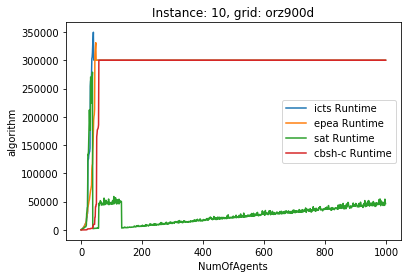

In [243]:
instance_id=10
gridname='orz900d'
plot_problem_runtime_hist(df,instance_id,gridname,runtime_cols)